In [1]:
# Cell 1 — imports + config
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

try:
    from statsmodels.tsa.stattools import acf as sm_acf
    _HAS_STATSMODELS = True
except Exception:
    _HAS_STATSMODELS = False

paths1_dir = "paths1"
paths2_dir = "paths2"

MAX_LAG = 2000   # change if you want
ALPHA   = 2.0    # cutoff band multiplier (tau = ALPHA / sqrt(n))


In [2]:
# Cell 2 — helpers (ACF + plotting)
def read_ensemble_csv(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(file_path)
    # Expect columns: theta1,w1,theta2,w2 (or similar order)
    if df.shape[1] < 4:
        raise ValueError(f"Expected >=4 columns, got {df.shape[1]} in {file_path}")
    df = df.iloc[:, :4].copy()
    df.columns = ["theta1", "w1", "theta2", "w2"]
    return df

def compute_acf(x: np.ndarray, max_lag: int) -> np.ndarray:
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    n = len(x)
    if n < 3:
        return np.full(max_lag + 1, np.nan)

    max_lag = min(max_lag, n - 2)

    if _HAS_STATSMODELS:
        return sm_acf(x, nlags=max_lag, fft=True, missing="drop")

    # Fallback: FFT-based autocorrelation -> normalize to correlation
    x = x - x.mean()
    n = len(x)
    m = 1 << (2 * n - 1).bit_length()
    fx = np.fft.rfft(x, n=m)
    acov = np.fft.irfft(fx * np.conjugate(fx), n=m)[: max_lag + 1]
    acov /= np.arange(n, n - (max_lag + 1), -1)  # unbiased-ish
    if acov[0] == 0:
        return np.zeros(max_lag + 1)
    return acov / acov[0]

def plot_acfs_2x2(acfs: dict, title: str):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
    keys = ["theta1", "w1", "theta2", "w2"]
    for ax, k in zip(axes.ravel(), keys):
        a = acfs[k]
        ax.plot(np.arange(len(a)), a, linewidth=1.2)
        ax.axhline(0.0, linewidth=1.0)
        ax.set_title(k)
        ax.set_xlabel("lag")
        ax.set_ylabel("ACF")
    fig.suptitle(title, y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()


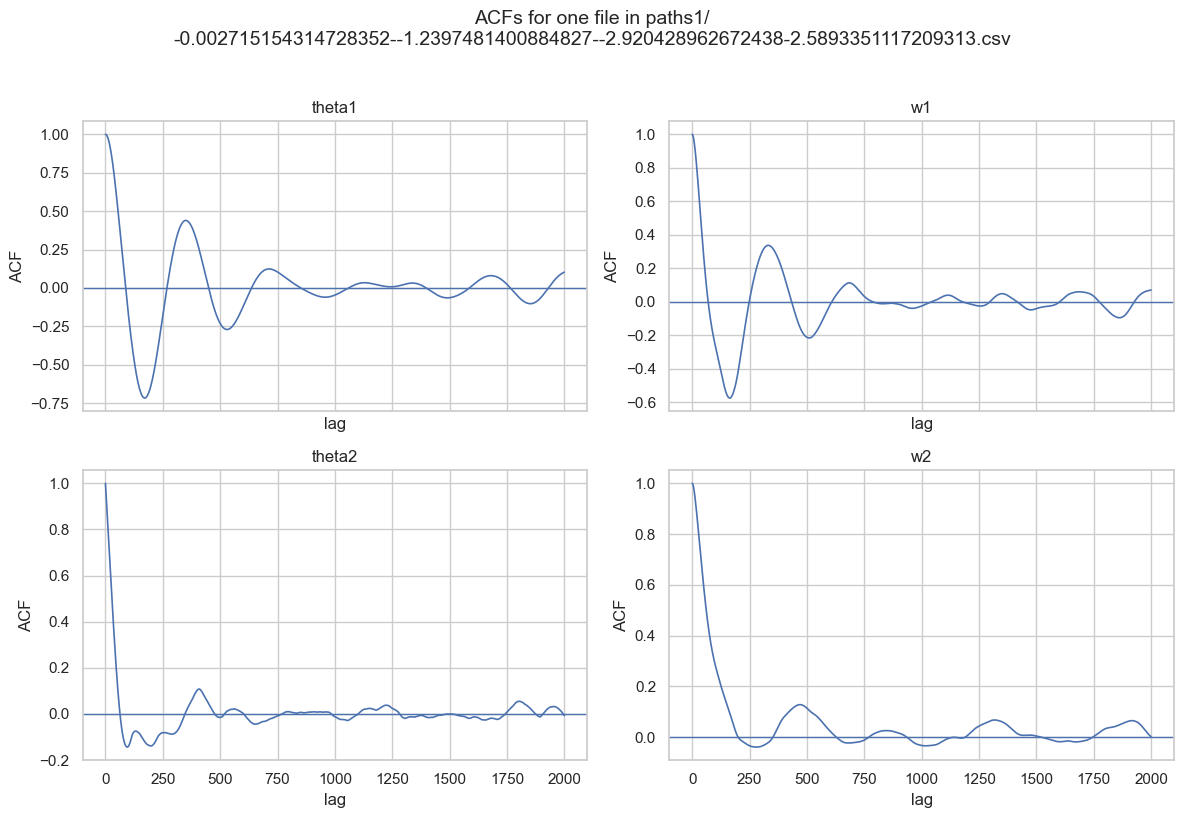

paths1/ example file: -0.002715154314728352--1.2397481400884827--2.920428962672438-2.5893351117209313.csv (n=100002, max_lag=2000, tau=0.006324)
m cutoffs: {'theta1': 2000, 'w1': 2000, 'theta2': 2000, 'w2': 1995}



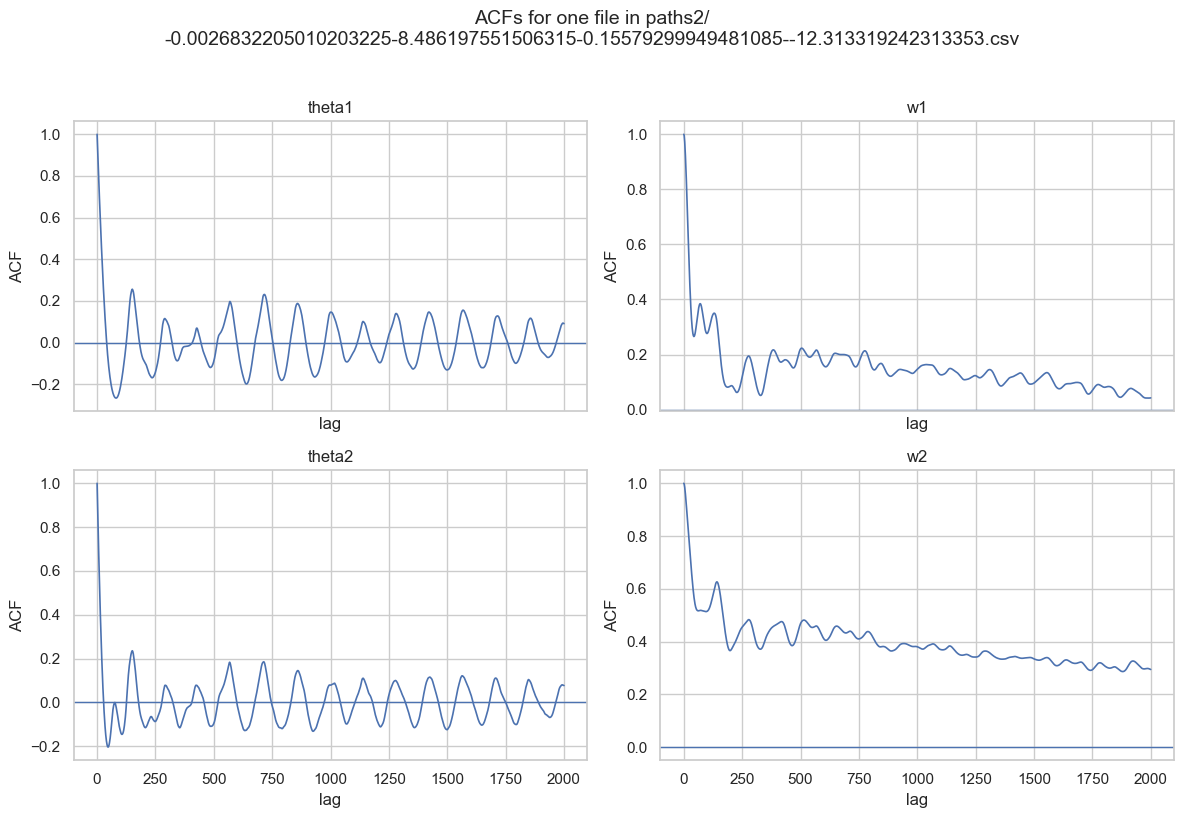

paths2/ example file: -0.0026832205010203225-8.486197551506315-0.15579299949481085--12.313319242313353.csv (n=100003, max_lag=2000, tau=0.006324)
m cutoffs: {'theta1': 2000, 'w1': 2000, 'theta2': 2000, 'w2': 2000}



In [3]:
# Cell 3 — cutoff m (method A) + “pick a file from each folder” ACF plots
def cutoff_m_from_acf(acf_vals: np.ndarray, n: int, alpha: float = 2.0) -> int:
    """
    Method A: m = smallest k such that |acf(j)| <= tau for all j >= k up to max lag.
    tau = alpha / sqrt(n)
    Returns max_lag if no such k exists.
    """
    tau = alpha / np.sqrt(max(n, 1))
    max_lag = len(acf_vals) - 1

    # ignore lag 0
    tail_ok = np.abs(acf_vals[1:]) <= tau
    # For each k, we need all j>=k to be ok => suffix AND
    suffix_all_ok = np.empty_like(tail_ok, dtype=bool)
    running = True
    for i in range(len(tail_ok) - 1, -1, -1):
        running = running and bool(tail_ok[i])
        suffix_all_ok[i] = running

    # k corresponds to index in acf array; tail_ok starts at lag=1
    for k in range(1, max_lag + 1):
        if suffix_all_ok[k - 1]:
            return k
    return max_lag

def pick_one_csv(folder: str) -> str:
    files = sorted(glob.glob(os.path.join(folder, "*.csv")))
    if not files:
        raise FileNotFoundError(f"No CSV files found in {folder}/")
    return files[0]

for folder in [paths1_dir, paths2_dir]:
    fp = pick_one_csv(folder)
    df = read_ensemble_csv(fp)
    n = len(df)

    max_lag = min(MAX_LAG, n - 2)
    acfs = {col: compute_acf(df[col].to_numpy(), max_lag) for col in df.columns}

    plot_acfs_2x2(acfs, title=f"ACFs for one file in {folder}/\n{os.path.basename(fp)}")

    ms = {col: cutoff_m_from_acf(acfs[col], n=n, alpha=ALPHA) for col in df.columns}
    print(f"{folder}/ example file: {os.path.basename(fp)} (n={n}, max_lag={max_lag}, tau={ALPHA/np.sqrt(n):.4g})")
    print("m cutoffs:", ms)
    print()


In [4]:
# Cell 4 — run over all files + collect m cutoffs
def compute_cutoffs_for_folder(folder: str, max_lag: int, alpha: float = 2.0) -> pd.DataFrame:
    files = sorted(glob.glob(os.path.join(folder, "*.csv")))
    if not files:
        raise FileNotFoundError(f"No CSV files found in {folder}/")

    rows = []
    for fp in files:
        df = read_ensemble_csv(fp)
        n = len(df)
        if n < 3:
            continue
        nlags = min(max_lag, n - 2)

        acfs = {col: compute_acf(df[col].to_numpy(), nlags) for col in df.columns}
        ms = {col: cutoff_m_from_acf(acfs[col], n=n, alpha=alpha) for col in df.columns}

        rows.append({
            "file": os.path.basename(fp),
            "n": n,
            "max_lag": nlags,
            "tau": alpha / np.sqrt(n),
            **{f"m_{col}": ms[col] for col in df.columns},
        })

    return pd.DataFrame(rows)

cutoffs1 = compute_cutoffs_for_folder(paths1_dir, max_lag=MAX_LAG, alpha=ALPHA)
cutoffs2 = compute_cutoffs_for_folder(paths2_dir, max_lag=MAX_LAG, alpha=ALPHA)

print("paths1 summary:")
display(cutoffs1.describe(include="all"))
print("\npaths2 summary:")
display(cutoffs2.describe(include="all"))


paths1 summary:


,file,n,max_lag,tau,m_theta1,m_w1,m_theta2,m_w2
count,1000,1000.000000,1000.0,1.000000e+03,1000.00000,1000.000000,1000.000000,1000.000000
unique,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,-0.002715154314728352--1.2397481400884827--2.9...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,100002.003000,2000.0,6.324492e-03,1997.75800,1996.888000,1993.821000,1993.617000
std,NaN,0.054717,0.0,1.730251e-09,15.34343,11.919124,16.971122,21.900318
min,NaN,100002.000000,2000.0,6.324460e-03,1642.00000,1872.000000,1844.000000,1737.000000
25%,NaN,100002.000000,2000.0,6.324492e-03,2000.00000,2000.000000,2000.000000,2000.000000
50%,NaN,100002.000000,2000.0,6.324492e-03,2000.00000,2000.000000,2000.000000,2000.000000
75%,NaN,100002.000000,2000.0,6.324492e-03,2000.00000,2000.000000,2000.000000,2000.000000



paths2 summary:


,file,n,max_lag,tau,m_theta1,m_w1,m_theta2,m_w2
count,1000,1000.000000,1000.0,1.000000e+03,1000.000000,1000.000000,1000.00000,1000.000000
unique,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,-0.0026832205010203225-8.486197551506315-0.155...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,100002.004000,2000.0,6.324492e-03,1998.102000,1998.150000,1998.28000,1998.042000
std,NaN,0.063151,0.0,1.996920e-09,7.424198,7.341076,5.80873,8.503443
min,NaN,100002.000000,2000.0,6.324460e-03,1930.000000,1924.000000,1937.00000,1902.000000
25%,NaN,100002.000000,2000.0,6.324492e-03,2000.000000,2000.000000,2000.00000,2000.000000
50%,NaN,100002.000000,2000.0,6.324492e-03,2000.000000,2000.000000,2000.00000,2000.000000
75%,NaN,100002.000000,2000.0,6.324492e-03,2000.000000,2000.000000,2000.00000,2000.000000


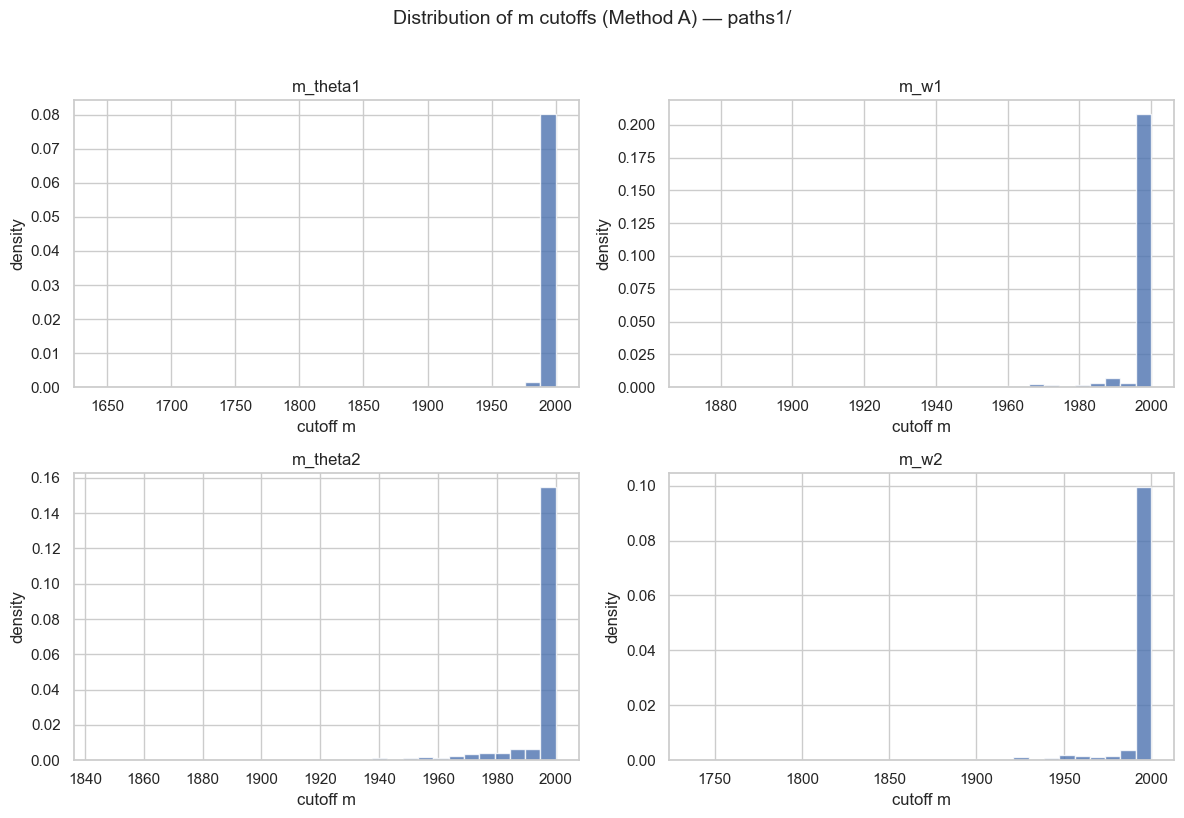

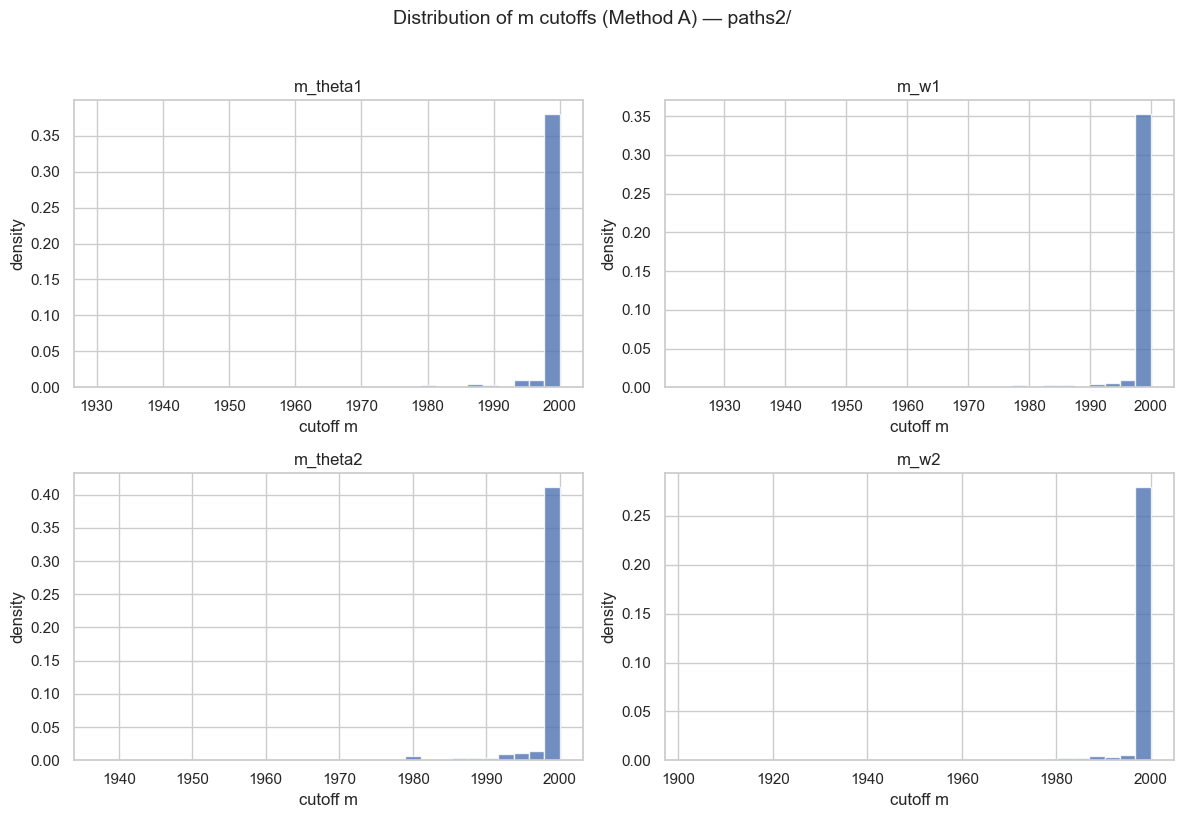

In [5]:
# Cell 5 — plot distributions of m cutoffs (two 2x2 plots: one per folder)
def plot_cutoff_distributions(df_cutoffs: pd.DataFrame, title: str):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    keys = ["theta1", "w1", "theta2", "w2"]

    for ax, k in zip(axes.ravel(), keys):
        series = df_cutoffs[f"m_{k}"].dropna().astype(int)
        ax.hist(series, bins=30, density=True, alpha=0.8)
        ax.set_title(f"m_{k}")
        ax.set_xlabel("cutoff m")
        ax.set_ylabel("density")

    fig.suptitle(title, y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

plot_cutoff_distributions(cutoffs1, title=f"Distribution of m cutoffs (Method A) — {paths1_dir}/")
plot_cutoff_distributions(cutoffs2, title=f"Distribution of m cutoffs (Method A) — {paths2_dir}/")
